In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import time
import numpy as np

In [10]:
#Hyper Parameters
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
LR = 0.0001
BATCH_SIZE = 32
EPOCHS = 20

Device: cuda:0


In [11]:
train_dataset = datasets.CelebA(root= './data/',
                               split='train',
                               transform=transforms.Compose([
                                   transforms.CenterCrop((128, 128)),
                                   transforms.ToTensor()]),
                               download=False)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size= BATCH_SIZE,
                          num_workers=2,
                          shuffle=True)

In [12]:
#Checking train_loader and data dimensionality
print('Training Set: \n')
for image, label in train_loader:
    print('Image batch dimension:', image.size())
    print('Label batch dimension:', label.size())
    break

Training Set: 

Image batch dimension: torch.Size([32, 3, 128, 128])
Label batch dimension: torch.Size([32, 40])


In [13]:
#All 40 unique labels from the dataset
label_maps={}
for num, label in enumerate(train_dataset.attr_names):
    label_maps[num] = label

label_maps.popitem()
label_maps

{0: '5_o_Clock_Shadow',
 1: 'Arched_Eyebrows',
 2: 'Attractive',
 3: 'Bags_Under_Eyes',
 4: 'Bald',
 5: 'Bangs',
 6: 'Big_Lips',
 7: 'Big_Nose',
 8: 'Black_Hair',
 9: 'Blond_Hair',
 10: 'Blurry',
 11: 'Brown_Hair',
 12: 'Bushy_Eyebrows',
 13: 'Chubby',
 14: 'Double_Chin',
 15: 'Eyeglasses',
 16: 'Goatee',
 17: 'Gray_Hair',
 18: 'Heavy_Makeup',
 19: 'High_Cheekbones',
 20: 'Male',
 21: 'Mouth_Slightly_Open',
 22: 'Mustache',
 23: 'Narrow_Eyes',
 24: 'No_Beard',
 25: 'Oval_Face',
 26: 'Pale_Skin',
 27: 'Pointy_Nose',
 28: 'Receding_Hairline',
 29: 'Rosy_Cheeks',
 30: 'Sideburns',
 31: 'Smiling',
 32: 'Straight_Hair',
 33: 'Wavy_Hair',
 34: 'Wearing_Earrings',
 35: 'Wearing_Hat',
 36: 'Wearing_Lipstick',
 37: 'Wearing_Necklace',
 38: 'Wearing_Necktie',
 39: 'Young'}

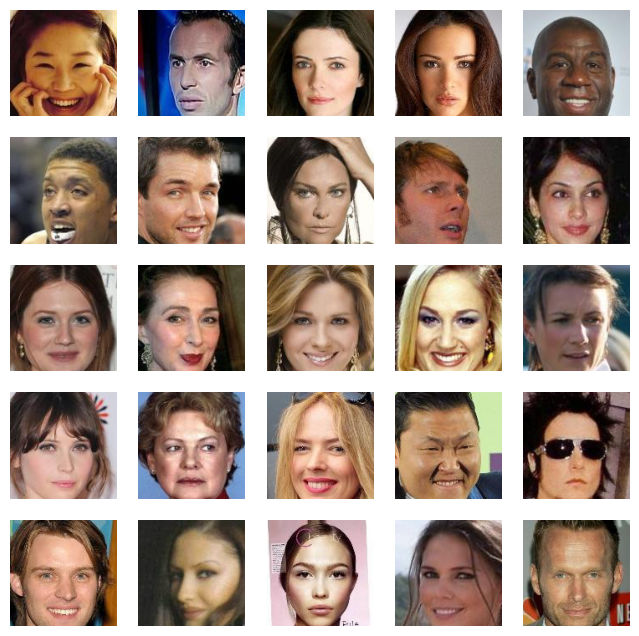

In [14]:
#Visualising few sample images from few categories
figure = plt.figure(figsize=(8,8))
cols, rows = 5 , 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label_tensor = train_dataset[sample_idx]
    label = label_tensor.sum().item()
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [15]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]
        
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), 
            nn.Flatten()
        )
        self.mu = torch.nn.Linear(4096, 200)
        self.log_var = torch.nn.Linear(4096, 200)
        self.Decoder = nn.Sequential(
            nn.Linear(200, 4096), 
            Reshape(-1, 64, 8, 8), 
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=0), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1),
            Trim(), 
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(log_var/2.)
        return z
        
    def forward(self, x):
        x = self.Encoder(x)
        mean, var = self.mu(x), self.log_var(x)
        encoded = self.reparameterize(mean, var)
        decoded = self.Decoder(encoded)
        return encoded, mean, var, decoded

In [16]:
vae = VariationalAutoEncoder()
vae.to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(),lr = LR)

In [17]:
def objective_function (mean, log_var, features, decoded, loss_fn):
    
    kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var),axis=1)
    batchsize = kl_div.size(0)
    kl_div = kl_div.mean(0)

    pixelwise = loss_fn(decoded, features, reduction='none')
    pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)
    pixelwise = pixelwise.mean()

    loss = 1 * pixelwise + kl_div
    return loss, pixelwise, kl_div
    
def compute_epoch_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss
            
        curr_loss = curr_loss / num_examples
        return curr_loss

In [18]:
def train_model(epochs, model, optimizer, device, train_loader,logging):
    log_dict = {'train_combined_loss_per_batch':[],
               'train_reconstruction_loss_batch':[],
               'train_kl_loss':[]}
    
    loss_fn = F.mse_loss
    start_time = time.time()
    for epoch in range(epochs):
        model.train()

        for batch_idx, (features, _ ) in enumerate(train_loader):
            features = features.to(device)

            encoded, mean, log_var, decoded = model(features)
            loss, pixelwise, kl_div = objective_function(mean=mean, log_var=log_var, features=features, decoded=decoded, loss_fn=loss_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_batch'].append(pixelwise.item())
            log_dict['train_kl_loss'].append(kl_div.item())


            if not batch_idx % logging:
                print('Epoch: %03d/%03d | Batch %04d/%04d | loss: %.4f'
                     % (epoch+1, epochs, batch_idx, len(train_loader), loss))
                
        
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return log_dict

In [19]:
log_dict = train_model(epochs=EPOCHS,model=vae, optimizer=optimizer,
                       device=DEVICE, train_loader=train_loader,logging=500)

Epoch: 001/020 | Batch 0000/5087 | loss: 4804.2808
Epoch: 001/020 | Batch 0500/5087 | loss: 1061.4437
Epoch: 001/020 | Batch 1000/5087 | loss: 921.9915
Epoch: 001/020 | Batch 1500/5087 | loss: 843.8856
Epoch: 001/020 | Batch 2000/5087 | loss: 742.7716
Epoch: 001/020 | Batch 2500/5087 | loss: 658.5161
Epoch: 001/020 | Batch 3000/5087 | loss: 752.3173
Epoch: 001/020 | Batch 3500/5087 | loss: 643.8232
Epoch: 001/020 | Batch 4000/5087 | loss: 625.7892
Epoch: 001/020 | Batch 4500/5087 | loss: 687.9143
Epoch: 001/020 | Batch 5000/5087 | loss: 667.2949
Time elapsed: 2.63 min
Epoch: 002/020 | Batch 0000/5087 | loss: 638.7503
Epoch: 002/020 | Batch 0500/5087 | loss: 634.6573
Epoch: 002/020 | Batch 1000/5087 | loss: 636.2556
Epoch: 002/020 | Batch 1500/5087 | loss: 575.6981
Epoch: 002/020 | Batch 2000/5087 | loss: 569.8435
Epoch: 002/020 | Batch 2500/5087 | loss: 619.4794
Epoch: 002/020 | Batch 3000/5087 | loss: 502.9582
Epoch: 002/020 | Batch 3500/5087 | loss: 556.4696
Epoch: 002/020 | Batch 40

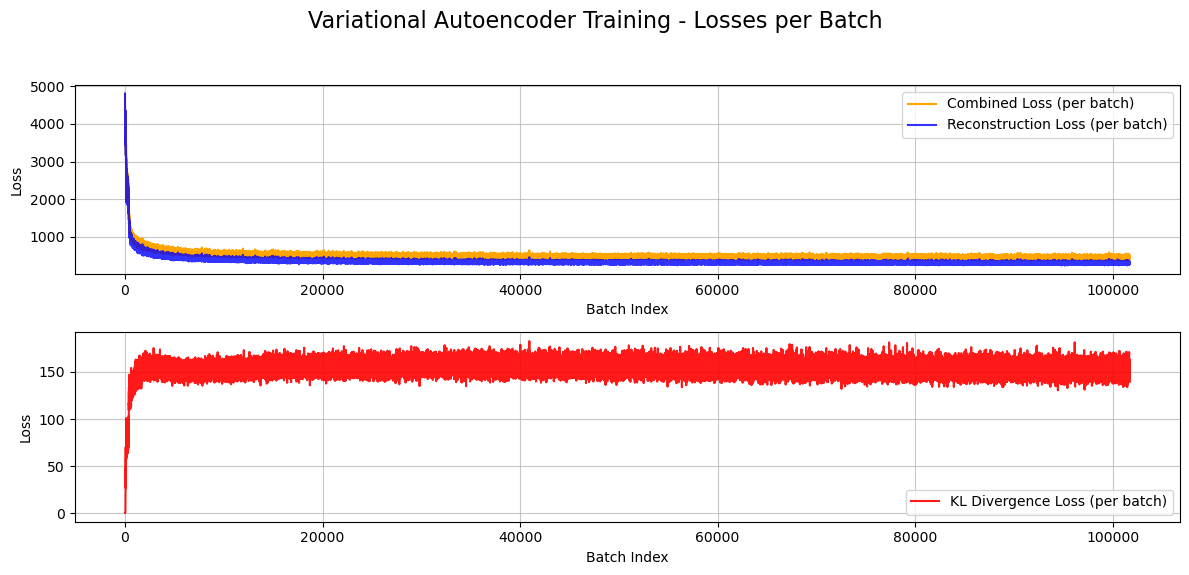

In [20]:
def plot_losses(log_dict, title):
    plt.figure(figsize=(12, 6))

    # Plot losses per batch
    plt.subplot(2, 1, 1)
    plt.plot(log_dict['train_combined_loss_per_batch'], label='Combined Loss (per batch)', color='orange', alpha=1)
    plt.plot(log_dict['train_reconstruction_loss_batch'], label='Reconstruction Loss (per batch)',linestyle='-', color='blue', alpha=0.8)
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    #plt.title(f'{title} - Losses per Batch')
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(True, linestyle='-', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(log_dict['train_kl_loss'], label='KL Divergence Loss (per batch)',color='red', alpha=0.9)
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    plt.suptitle(f'{title} - Losses per Batch', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(True, linestyle='-', alpha=0.7)
    plt.show()
    
plot_losses(log_dict, 'Variational Autoencoder Training')

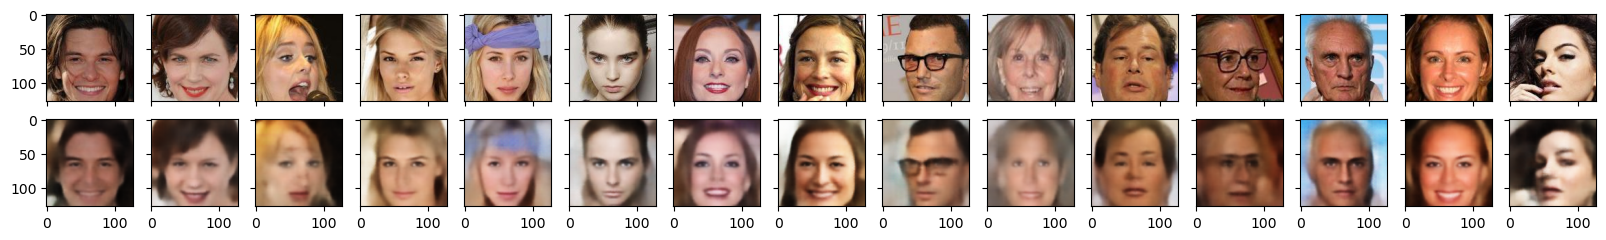

In [21]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
plot_generated_images(data_loader=train_loader,
                      model=vae,
                      device=DEVICE,
                      modeltype='VAE')